# **Watermark Removal CNN via PyTorch**

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body>
    </header>
    <section>
        <h2><strong>Project:</strong> Watermark Removal CNN</h2>
        <p><strong>Machine Learning Engineer (aspiring):</strong> Ian H. Ryan</p>
        <p><strong>Version:</strong> 0.1</p>
        <p><strong>Timeline:</strong> May 22, 2025 - June 24th, 2025</p>
        <p><strong>Description:</strong> 
  </p>

  <p>
    I have been practicing scraping images from the world wide web to create random datasets and a portion of said images contain watermarks. I thought that it would be a nice challenge to attempt making a Deep Learning model that removes watermarks from images. I found a research paper on ArXiv called <a href="https://arxiv.org/html/2403.05807v1" target="_blank">
        A self-supervised CNN for image watermark removal
    </a> by Chunwei Tian, Member, IEEE, Menghua Zheng, Tiancai Jiao, Wangmeng Zuo, Senior Member, IEEE, Yanning
Zhang, Senior Member, IEEE, Chia-Wen Lin, Fellow, IEEE from 9 Mar 2024 which I used to learn from and reference for this project. Since finding image pairs of clean & watermarked images is difficult, I opted to create synthetic watermarks.
  </p>
    </section>
</body>
</html>

# Index

## **Table of Contents**
- [Libraries & Imports](#libraries--imports)
  - [Libraries](#libraries)
  - [Imports](#imports)
- [CUDA](#icuda)
  - [Check GPU Availability for CUDA](#check-gpu-availability-for-cuda)
  - [CUDA allocation limiting ~64mb](#cuda-allocation-limiting-64mb)
- [Seed](#seed)
- [Dataset Description](#datasetinfo)
- [CNN Model](#cnn-model)
  - [Model Architecture](#model-arch)
  - [MixedLoss Loss Function](#loss-func)
  - [Total Parameters](#tot-param)
- [Data Generation (Self-Supervised)](#data-gen-ss)
  - [DataSet Class](#data-class)
- [Hyperparameters](#hyperparameters)
  - [Batch Size, Epochs, Learning Rate, Weight Decay](#batch-epoch-lr-weightdecay-steps)
- [Transform](#transform)
- [Pathing](#pathing)
- [Data Loader](#data-loaders)
- [Criterion, Optimizer, & Scaler for AMP](#crit-opt-scaler-amp)
- [Training CNN Model](#training-cnn-model)
- [Save Summary for Regression Task Report JSON](#save-sum-reg-report)
- [Log Training History](#log-training-history)
- [Create ChangeLog](#create-changelog)
- [Create ChangeLog & Config](#create-changelog--config)
- [Save Model Weights or Save Model of Training](#save-model-weights-or-save-model-of-training)
- [Test Accuracy of CNN Training](#test-accuracy-of-cnn-training)
- [Visualizations & Metrics](#vis-metrics)
  - [Metrics](#metrics)
    - [Summary](#summary)
    - [Evaluation Cell (For Restoration CNN)](#evaluate-cell)
    - [Test Results CSV & JSON](#test-results)
  - [Visuals](#visuals)
    - [Residual Histogram](#res-hist)
    - [Local PSNR/SSIM Maps](#loc-psnrssim)
    - [Side by side Comparison](#side-comp)
    - [Watermark Residual](#wm-res)
    - [Training Progress](#train-prog)
    - [Watermark Attention](#wm-att)
    - [Batch Processing](#batch-proc)
    - [Learning Rate Visual](#learning-rate-visual)
    - [Train Loss, Peak Signal-to-Noise Ratio, Structural Similarity Index](#ind-plots)
    - [Residual Error](#res-error)
    - [Multi-Layer Activation](#mult-act)
    - [Feature Activation Maps (Decoder Focus)](#dec-focus)
    - [Kernel/Visualizations](#kernelvisualizations)
    - [Gradient Visualization](#gradient-visualization)
- [Literature Cited](#literature-cited)
- [Environment](#environment)
- [Recommended Resources](#recommended-resources)
- [Permission](#permission)

# **Libraries & Imports** <a id="libim"></a>

## Libraries<a id="libraries"></a>

`!pip freeze > requirements.txt` done in a code cell will save all the versions of the pip installs for you. Excellent for documentation and recreatability.

In [1]:
%%capture

# instal the libraries
!pip install -U -q -r requirements.txt

Restart Kernel by running following cell.

In [2]:
from IPython.display import HTML, display
def restart_kernel_and_run_all_cells():
    display(HTML(
        '''
            <script>
                code_show = false;
                var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
                cell_idx++;
                function restart(){
                    IPython.notebook.kernel.restart();
                    IPython.notebook.execute_cells([cell_idx])
                }
                restart()
            </script>
        '''
    ))
#print("Before you continue, wait until the kernel is ready again.")
restart_kernel_and_run_all_cells()

## Imports <a id="imports"></a>

In [3]:
%matplotlib inline

# Python
import os, shutil, time, gc, random, json, math, csv, yaml
from collections import Counter, defaultdict
from glob import glob
# Image Processing
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter
import cv2
import imageio
# Math & Arrays
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
# PyTorch & TorchVision
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
from torchvision import transforms, models
from torchvision.models import vgg16
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import ImageFolder
# Visualization tools
from torchviz import make_dot
# Model explainability
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import normalize, to_pil_image
# Model summary
from torchsummary import summary
# Sklearn utilities
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    precision_recall_curve,
    mean_squared_error
)
from skimage.metrics import (
    peak_signal_noise_ratio as psnr,
    structural_similarity as ssim,
    mean_squared_error as sk_mse,
    normalized_root_mse as nrmse
)
try:
    from skimage.metrics import variation_of_information as voi
except ImportError:
    from skimage.metrics import adapted_rand_error as voi  # Fallback
    print("Note: Using adapted_rand_error instead of variation_of_information")
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# Progress bar
from tqdm import tqdm
# Date & Time
from datetime import datetime
# Captum
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
# Loss Functions
import kornia.losses
import kornia.color as kc
from kornia.losses import ssim_loss, SSIMLoss, MS_SSIMLoss
# For watermark synthesis
from wand.image import Image as WandImage
from scipy.ndimage import gaussian_filter
# For advanced metrics
import lpips
# Add to image processing section
import exifread
from difflib import SequenceMatcher

# CUDA

## Check GPU Availability for CUDA? <a id="checkgpucuda"></a>

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("# of GPUs Available:", torch.cuda.device_count())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

CUDA available: True
# of GPUs Available: 1


'cuda'

## CUDA allocation limiting ~64mb
limit cuda memory if errors persist

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

# Seed

In [6]:
def set_seed(seed=42):
    random.seed(seed)              # Python’s built-in random module
    np.random.seed(seed)           # NumPy random seed
    torch.manual_seed(seed)        # PyTorch seed for CPU
    torch.cuda.manual_seed_all(seed)  # PyTorch seed for all CUDA GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
set_seed()
seed = 42

# Dataset Description <a id="download-datasets"></a>
This project is trained from data that I scraped off of the internet from various sources while making image scrapers. With that being said, I will not be providing downloads to the data.
<p>
- 1000 images, 996 jpg, 4 png file types. <br>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
        }
        h2 {
            color: #333;
        }
        a {
            color: #0066cc;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
    </style>
</head>
<body>


<p>
    If you need datasets consider checking out: 
    <a href="https://www.kaggle.com/datasets/" target="_blank">
        Kaggle | 
    </a>
    <a href="https://public.roboflow.com/" target="_blank">
        Roboflow | 
    </a>
    <a href="https://cocodataset.org/#download" target="_blank">
        COCO
    </a>
</p>

</body>
</html>

# CNN Model <a id="cnn-model"></a>

### Define CNN Model Architecture <a id="define-cnn-model"></a>

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the CNN
# modular DoubleConv used in encoder & decoder
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),  # activation 1
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)  # activation 2
        )

    def forward(self, x):
        return self.conv(x)

# transposed conv to avoid interpolation artifcats from bilinear & for learnable upsampling.
# modular UpConv
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)
        
# contains encoder-decoder struct & perceptual path
class WatermarkRemover(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder
        self.enc1 = DoubleConv(3, 48) # full res
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(48, 96) # 1/2 res
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(96, 144) # 1/4 res
        )

        # bottleneck
        self.bottleneck = nn.Sequential(
            # nn.MaxPool2d(2),
            # DoubleConv(144, 192), # 1/8 res
            # Add attention gate
            # nn.Conv2d(192, 192, 1),
            # nn.Sigmoid()  # Spatial attention
            nn.MaxPool2d(2),
            DoubleConv(144, 256),  # Expanded to 256 channels
            nn.Conv2d(256, 256, 3, padding=1),  # 3x3 conv for spatial context
            nn.Sigmoid()
        )

        # decoder
        # self.up1 = UpConv(192, 144)
        self.up1 = UpConv(256, 144)
        self.up2 = UpConv(144, 96)
        self.up3 = UpConv(96, 48)

        # Attention gates for each decoder level
        self.attn_gate1 = nn.Sequential(
            # nn.Conv2d(144*2, 1, 1),  # Processes concatenated features
            # nn.Sigmoid()
            nn.Conv2d(144*2, 144, 3, padding=1),  # Wider channel capacity
            nn.LeakyReLU(0.1),
            nn.Conv2d(144, 1, 1),
            nn.Sigmoid()
        )
        self.attn_gate2 = nn.Sequential(
            # nn.Conv2d(96*2, 1, 1),
            # nn.Sigmoid()
            nn.Conv2d(96*2, 96, 3, padding=1),  # Wider channel capacity
            nn.LeakyReLU(0.1),
            nn.Conv2d(96, 1, 1),
            nn.Sigmoid()
        )
        self.attn_gate3 = nn.Sequential(
            # nn.Conv2d(48*2, 1, 1),
            # nn.Sigmoid()
            nn.Conv2d(48*2, 48, 3, padding=1),  # Wider channel capacity
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 1, 1),
            nn.Sigmoid()
        )
        
        self.dec1 = DoubleConv(144 + 144, 144)
        self.dec2 = DoubleConv(96 + 96, 96)
        self.dec3 = DoubleConv(48 + 48, 48)

        # last conv
        self.final_conv = nn.Conv2d(48, 3, kernel_size=1)  # Output RGB

        # VGG for perceptual loss (non trainable)
        self.vgg = vgg16(pretrained=True).features[:16].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        # encode
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.bottleneck(x3) # with self-attention
        x4 = x4 * x4  # Apply self-attention

        # decode w skip connections (now attention gates have to see if that still includes slip connections)
        u1 = self.up1(x4)
        cat1 = torch.cat([u1, x3], dim=1)
        attn1 = self.attn_gate1(cat1)
        d1 = self.dec1(cat1 * attn1)

        # Level 2
        u2 = self.up2(d1)
        cat2 = torch.cat([u2, x2], dim=1)
        attn2 = self.attn_gate2(cat2)
        d2 = self.dec2(cat2 * attn2)
        
        # Level 3
        u3 = self.up3(d2)
        cat3 = torch.cat([u3, x1], dim=1)
        attn3 = self.attn_gate3(cat3)
        d3 = self.dec3(cat3 * attn3)

        return torch.sigmoid(self.final_conv(d3)) # .clamp(0, 1)  # [0, 1] pixel values  Double safety bc of output Issue: Negative PSNR values without
        
    # only used during training to compute a texture-aware loss based on VGG features.
    # Extra feature that helps generate more realistic results (especially for watermark removal).
    def perceptual_features(self, x):
        # Normalize like ImageNet for VGG
        # mean & std are hard coded because of the vgg16 pre-trained model
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(x.device)
        x = (x - mean) / std # VGG Normalize
        # Extract multi-layer features (conv1_2, conv2_2, conv3_2)
        features = []
        for i, layer in enumerate(self.vgg[:16]):  # Stop before conv4_1
            x = layer(x)
            if i in {1, 6, 11}:  # Indices of conv1_2, conv2_2, conv3_2 in VGG16
                features.append(F.normalize(x))  # L2-normalize each feature map
        
        # Concatenate flattened features
        return torch.cat([f.flatten(start_dim=1) for f in features], dim=1)


### Loss Function

#### Lab Color Loss - L1 loss in Lab Space

LAB Loss Focus on Luminance
the luminance (L-channel) in LAB color space improves watermark removal, especially for PSNR/SSIM.
The LAB color space separates:
L (Lightness): Pure luminance (0 = black, 100 = white)
A: Green → Red spectrum
B: Blue → Yellow spectrum
For RGB → LAB conversion:
Why Luminance (L) Matters Most
A. SSIM is Luminance-Dominant
SSIM’s core metric focuses on luminance similarity (with contrast/structure as secondary terms).

By aligning LAB’s L-channel with SSIM, we directly optimize for what SSIM measures.

B. Watermarks are Luminance-Sparse
Most watermarks alter brightness (L-channel) more than color (A/B).

Example: A gray "©" watermark primarily distorts L, not A/B.

C. Human Perception
The eye detects luminance changes 5x more sensitively than color shifts

In [9]:
def lab_color_loss(pred, target):
    # Luminance focused LAB loss (70% weight on L-channel, 30% on A/B channels)
    # Inputs in [0, 1] range

    pred_lab = kc.rgb_to_lab(pred.clamp(0, 1))  # [B, 3, H, W]
    target_lab = kc.rgb_to_lab(target.clamp(0, 1))
    
    # Split into L and A/B components
    pred_L, pred_AB = pred_lab[:, 0:1], pred_lab[:, 1:3]  # L: [B,1,H,W], AB: [B,2,H,W]
    target_L, target_AB = target_lab[:, 0:1], target_lab[:, 1:3]
    
    # Weighted losses
    L_loss = F.l1_loss(pred_L, target_L) * 0.7  # 70% weight to luminance
    AB_loss = F.l1_loss(pred_AB, target_AB) * 0.3  # 30% to color
    
    return L_loss + AB_loss

#### ColorAwareLoss - alpha, beta, gamma, & delta

In [10]:
class ColorAwareLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.25, gamma=0.1, delta=0.1):
        """
        Enhanced with SSIM while preserving color awareness
        Args:
            alpha: weight for VGG-based perceptual loss (0.5 recommended)
            beta: weight for Lab color fidelity loss (0.25 recommended)
            gamma: weight for SSIM loss (0.1 recommended)
            delta: weight for edge-preserving Laplacian loss
        """
        super().__init__()
        self.alpha = alpha  # Perceptual weight
        self.beta = beta    # Color weight
        self.gamma = gamma  # SSIM weight
        self.delta = delta  # Laplacian weight
        
        # Core losses
        self.l1 = nn.L1Loss(reduction='none') # (reduction='none') in place of () for mask We'll reduce manually with mask
        self.ssim_loss = SSIMLoss(window_size=11)

        # laplacian kernel
        """
        self.laplacian_kernel = torch.tensor(
            [[0, 1, 0],
             [1, -4, 1],
             [0, 1, 0]], dtype=torch.float32
        ).unsqueeze(0).unsqueeze(0)  # Shape: (1,1,3,3)
        """
        self.laplacian_kernel = torch.tensor(
            [[[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]]], dtype=torch.float32).unsqueeze(0)
        
        # Optional: Cache for loss logging
        self.last_losses = {}

    """
    def laplacian_loss(self, img1, img2):
        kernel = self.laplacian_kernel.to(img1.device)
        img1_edge = F.conv2d(img1, kernel, padding=1, groups=1)
        img2_edge = F.conv2d(img2, kernel, padding=1, groups=1)
        return self.l1(img1_edge, img2_edge)
    """
    def laplacian_loss(self, img1, img2):
        B, C, H, W = img1.shape
        kernel = self.laplacian_kernel.to(img1.device).expand(C, 1, 3, 3)
        img1_edge = F.conv2d(img1, kernel, padding=1, groups=C)
        img2_edge = F.conv2d(img2, kernel, padding=1, groups=C)
        return self.l1(img1_edge, img2_edge)

    def forward(self, pred, target, net, mask=None):
        # Structural L1 loss (pixel-level)
        structural_loss = self.l1(pred, target) # shape: [B, C, H, W]
        
        # Perceptual loss (VGG features)
        # pred_feat = net.perceptual_features(pred)
        # target_feat = net.perceptual_features(target)
        with torch.no_grad():
            pred_feat = net.perceptual_features(pred)
            target_feat = net.perceptual_features(target)
        perceptual_loss = self.l1(pred_feat, target_feat).mean()
        
        # Color fidelity (Lab space)
        color_loss = lab_color_loss(pred, target)

        # SSMI
        ssim_val = ssim_loss(pred, target, window_size=11)  # Already returns (1-SSIM)

        # Laplacian pixel wise
        edge_loss = self.laplacian_loss(pred, target)

        # mask bullshit if else
        if mask is not None:
            # Ensure shape: [B, 1, H, W] for broadcasting
            if mask.dim() == 3:
                mask = mask.unsqueeze(1)
            mask = mask.to(pred.device)
            num_pixels = torch.clamp(mask.sum(), min=1.0)

            # Apply mask and average over non-zero regions
            structural_loss = (structural_loss * mask).sum() / num_pixels
            edge_loss = (edge_loss * mask).sum() / num_pixels
        else:
            structural_loss = structural_loss.mean()
            edge_loss = edge_loss.mean()
        
        # Combined loss
        total_loss = (structural_loss +
                     self.alpha * perceptual_loss +
                     self.beta * color_loss +
                     self.gamma * ssim_val +
                      self.delta * edge_loss)
        
        # Cache values for logging
        self.last_losses = {
            'total': total_loss.item(),
            'l1': structural_loss.item(),
            'perceptual': perceptual_loss.item(),
            'color': color_loss.item(),
            'ssim': ssim_val.item(),
            'laplacian': edge_loss.item(),
            'edge': edge_loss.item()
        }
        
        return total_loss

    def get_last_losses(self):
        """Returns dictionary of most recent loss components"""
        return self.last_losses
net = WatermarkRemover().to(device)

/home/ian/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ian/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Total Parameters

In [11]:
# Calculate total parameters
total_params = sum(p.numel() for p in net.parameters())
# Calculate trainable parameters
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 5383366
Trainable Parameters: 3647878


# Data Generation (Self-Supervised) <a id="transforms-loaders"></a>

Unlike Image Classification CNNs where it goes:<br>
transform = transforms.Compose([...])<br>
train_dataset = ImageFolder(..., transform=transform)<br>
train_loader = DataLoader(train_dataset, ...)<br>
<br>
it goes:<br>
trasform (similarly in purpose via normalize, resize, augmentation)<br>
WatermarkDataset -> replaces ImageFolder, but dynamically generates pairs<br>
DataLoader(...) -> same role: batching and shuffling<br>
<br>
Differs: the dataset class (WatermarkDataset) creates training pairs dynamically using synthetic watermarks. In classification, the dataset is fixed and labeled.

In [12]:
# Data Synthesis via Self Supervised Pair Creation like the research paper
# Generate a semi random watermark
def generate_watermark(size, text=None, font_path=None, watermark_texts=None):
    """
    Creates realistic watermarks with:
    - Multi-scale patterns
    - Non-linear distortions
    - Color variations
    - Partial occlusions
    """
    width, height = size
    watermark = Image.new("RGBA", size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(watermark)

    watermark_texts = watermark_texts or [
            "CONFIDENTIAL", "DRAFT", "©2024", "SAMPLE", 
            "DO NOT COPY", str(time.time()), "WATERMARK",
            "MARCA DE AGUA", "DERECHOS RESERVADOS",
            "FILIGRANE", "DROITS D’AUTEUR",
            "WASSERZEICHEN", "URHEBERRECHT",
            "水印", "版权所有",
            "ウォーターマーク", "著作権",
            "워터마크", "저작권",
            "ВОДЯНОЙ ЗНАК", "АВТОРСКОЕ ПРАВО",
            "علامة مائية", "حقوق النشر",
            "वॉटरमार्क", "कॉपीराइट"
        ]

    text = text or random.choice(watermark_texts)
        
    # Font selection with fallback
    try:
        font_size = random.randint(min(size)//12, min(size)//6)
        font = ImageFont.truetype(font_path or "arial.ttf", font_size)
    except:
        font = ImageFont.load_default()
    
    # Multi-texture watermark
    for _ in range(random.randint(1, 3)):
        # Random positioning
        x = random.randint(-width//4, width)
        y = random.randint(-height//4, height)
        
        # Color variations
        opacity = random.randint(50, 180)
        hue_variation = random.randint(-30, 30)
        base_color = (255 + hue_variation, 
                     255 + hue_variation, 
                     255 + hue_variation, 
                     opacity)
        
        # Distortion parameters
        distortion = random.choice([
            None,
            ImageFilter.GaussianBlur(radius=random.uniform(0.5, 2.5)),
            ImageFilter.MinFilter(size=3),
            ImageFilter.RankFilter(size=3, rank=2)
        ])
        
        # Draw text or logo
        if random.random() < 0.9:  # 90% text
            text = random.choice(watermark_texts)
            draw.text((x, y), text, fill=base_color, font=font)
        else:  # 10% geometric pattern
            shape = random.choice(["circle", "rect", "line"])
            if shape == "circle":
                r = random.randint(10, min(size)//6)
                draw.ellipse([x, y, x+r, y+r], fill=base_color)
            elif shape == "rect":
                w, h = random.randint(20, width//4), random.randint(20, height//4)
                draw.rectangle([x, y, x+w, y+h], fill=base_color)
            else:
                draw.line([x, y, x+random.randint(50,200), y+random.randint(-50,50)], 
                        fill=base_color, width=random.randint(1,5))
        
        # Apply distortion
        if distortion:
            watermark = watermark.filter(distortion)
    
    # Random rotation with edge preservation
    angle = random.randint(-45, 45)
    if angle != 0:
        watermark = watermark.rotate(angle, expand=True, resample=Image.BICUBIC)
        # Crop back to original size
        watermark = watermark.crop(
            (watermark.width//2 - width//2,
             watermark.height//2 - height//2,
             watermark.width//2 + width//2,
             watermark.height//2 + height//2))
    
    # Partial occlusion (random erasure)
    if random.random() < 0.3:
        occlude = Image.new("L", size, 0)
        draw = ImageDraw.Draw(occlude)
        for _ in range(random.randint(1, 3)):
            x, y = random.randint(0, width), random.randint(0, height)
            draw.rectangle([x, y, x+random.randint(width//4, width//2), 
                          y+random.randint(height//4, height//2)], fill=255)
        watermark = Image.composite(
            Image.new("RGBA", size, (0,0,0,0)),
            watermark,
            occlude)
    
    return watermark

# Blend watermark into image using alpha mask
def apply_watermark(clean_img, watermark):
    """
    Overlays a watermark on the clean image using a randomized alpha mask.
    Args:
        clean_img (PIL.Image): Base clean image (RGB or RGBA)
        watermark (PIL.Image): Watermark image (RGBA)
    Returns:
        watermarked (PIL.Image): Image with watermark applied
        clean_rgb (PIL.Image): Clean RGB version
        mask (PIL.Image): Binary mask of where watermark was applied
    """
    clean_img = clean_img.convert("RGBA")
    wm = watermark.resize(clean_img.size)

    # Generate spatially-varying alpha mask
    alpha_np = np.random.uniform(0.3, 0.8, size=clean_img.size[::-1])  # shape: [H, W]
    alpha_mask = (alpha_np * 255).astype(np.uint8)
    alpha = Image.fromarray(alpha_mask).convert("L")

    # Merge alpha mask with watermark (to control transparency)
    wm.putalpha(alpha)

    # Option enhance watermark brightness or contrast
    if random.random() < 0.3:
        enhancer = ImageEnhance.Brightness(wm)
        wm = enhancer.enhance(random.uniform(0.6, 1.2))

    # Composite watermark over image
    watermarked = Image.alpha_composite(clean_img, wm)

    # Generate Binary Mask (thresholded alpha map)
    binary_mask = np.array(alpha) > 32  # threshold ~12% alpha
    binary_mask = Image.fromarray((binary_mask * 255).astype(np.uint8)).convert("L")

    return watermarked.convert("RGB"), clean_img.convert("RGB"), binary_mask

# Gen training pair (two different watermarked versions of same image)
def generate_pair(clean_img):
    wm1 = generate_watermark(clean_img.size)
    wm2 = generate_watermark(clean_img.size)
    img1, _, mask1 = apply_watermark(clean_img, wm1)  # input
    img2, _, _ = apply_watermark(clean_img, wm2)  # reference
    return img1, img2, mask1 

In [13]:
# Augmentation pipe
def get_augmentations(image_size=256):
    # Albumentations pipeline with realistic distortions
    return A.Compose([
        # Geometric transforms
        A.RandomResizedCrop(image_size, image_size, scale=(0.8, 1.2)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.8),
        
        # Color distortions
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.8),
        A.ToGray(p=0.1),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),

        # Noise and compression
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        A.GaussianBlur(blur_limit=(1, 3), p=0.3),
        A.ImageCompression(quality_lower=60, quality_upper=90, p=0.5),

        # Sensor effects
        A.RandomRain(p=0.1),
        A.RandomShadow(p=0.2),

        # Domain-specific
        A.PixelDropout(dropout_prob=0.01, p=0.3),
        A.CoarseDropout(max_holes=3, max_height=20, max_width=20, p=0.2),

        ToTensorV2()
    ], additional_targets={'reference': 'image'})

## Dataset Class

In [14]:
# enhanced watermark dataset
class WatermarkDataset(Dataset):
    def __init__(self, clean_images, transform=None, watermark_texts=None, return_mask=False):
        # Args: clean_images: List of PIL Images, transform: Albumentations transform, watermark_texts: Custom watermark texts (optional), return_mask: mask activation
        self.clean_images = clean_images
        self.transform = transform
        # ENG, SPAN, FR, GER, CH, JAP, KOR, RUSS, ARA, HIN
        self.watermark_texts = watermark_texts

        self.return_mask = return_mask
        
    def _generate_base_watermark(self):
        size = (512, 512)  # Generate large then resize
        text = random.choice(self.watermark_texts)
        # return generate_watermark(size, text)
        return generate_watermark(size, text=text, watermark_texts=self.watermark_texts)
    
    def __len__(self):
        return len(self.clean_images)
    
    def __getitem__(self, idx):
        clean_img = self.clean_images[idx]
        #wm = generate_watermark(clean_img.size, watermark_texts=self.watermark_texts)
        wm1 = generate_watermark(clean_img.size, watermark_texts=self.watermark_texts) # mask return only for wm1
        wm2 = generate_watermark(clean_img.size, watermark_texts=self.watermark_texts)
        
        # Apply watermark pair
        wm_img1, clean, mask = apply_watermark(clean_img, wm1)
        wm_img2, _, _ = apply_watermark(clean_img, wm2)
        
        if self.transform:
            transformed = self.transform(image=np.array(wm_img1),
                                     reference=np.array(wm_img2),
                                     mask=np.array(mask))
            wm_img1 = transformed['image']
            wm_img2 = transformed['reference']
            mask = transformed['mask']

        if self.return_mask:
            # Ensure mask is a tensor
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask)
            # Ensure shape is [1, H, W]
            if mask.dim() == 2:
                mask = mask.unsqueeze(0)
            mask = mask.float() / 255.0  # Normalize to [0, 1]
            return wm_img1, wm_img2, mask
        else:
            return wm_img1, wm_img2

# Hyperparameters - Batch Size, Epochs, Learning Rate, Weight Decay, Optimizer <a id="hyperparameters"></a>

In [15]:
batch_size = 8
epochs = 25
learning_rate = 0.001
weight_decay = 1e-5
# accumulation_steps = 2

## Transform

In [16]:
transform = get_augmentations(image_size=256)

## Pathing

In [17]:
# pathing
clean_image_paths = sorted(glob("data/clean_images/*.jpg") + glob("data/clean_images/*.png"))
clean_images = [Image.open(p).convert("RGB") for p in clean_image_paths]

# split %s
train_pct = 0.7
val_pct = 0.2
test_pct = 0.1

# Split dataset 
train_imgs, val_test_imgs = train_test_split(clean_images, test_size=(1 - train_pct), random_state=42)
val_imgs, test_imgs = train_test_split(val_test_imgs, test_size=(test_pct / (val_pct + test_pct)), random_state=42)

# print splits
print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

Train: 699, Val: 200, Test: 100


## DataLoader

In [18]:
# Datasets train val test
train_dataset = WatermarkDataset(train_imgs, transform=transform, return_mask=True)
val_dataset = WatermarkDataset(val_imgs, transform=transform, return_mask=False)
test_dataset = WatermarkDataset(test_imgs, transform=transform, return_mask=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Optional unified dataset for visualizations
dataset = WatermarkDataset(clean_images, transform=transform)

In [19]:
gc.collect()
torch.cuda.empty_cache()

## Loss Function, Optimizer, & GradScaler for AMP

In [20]:
criterion = ColorAwareLoss(alpha=0.3, beta=0.3, gamma=0.4, delta=0.1).to(device)

### **Optimizer & Learning Rate Scheduler**

In [21]:
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,  # Reduced from 0.01
    steps_per_epoch=len(train_loader),
    epochs=epochs + 2,
    pct_start=0.3,
    div_factor=10,  # init lr = max_lr/10
    final_div_factor=100  # final lr = max_lr/100
)

# Training CNN Model <a id="training-model"></a>

Training - during an epoch there is forward propogation, loss calculation, backward propogation and weight update

In [22]:
def compute_psnr(pred, target):
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    return np.mean([psnr(t, p, data_range=1.0) for p, t in zip(pred_np, target_np)])

def compute_ssim(pred, target):
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    return np.mean([
        ssim(t.transpose(1, 2, 0), p.transpose(1, 2, 0), data_range=1.0, channel_axis=2)
        for p, t in zip(pred_np, target_np)
    ])

def train_model(net, dataloader, val_loader, optimizer, criterion, scheduler, device, epochs=epochs, save_path="wm_best_model.pth", early_stop_patience=10):
    scaler = torch.cuda.amp.GradScaler()
    best_loss = float('inf')
    epochs_no_improve = 0
    warmup_optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4) #warmup learning rate

    train_losses, psnr_scores, ssim_scores, lrs = [], [], [], []
    val_losses, val_psnr_scores, val_ssim_scores = [], [], []

    gc.collect()
    torch.cuda.empty_cache()
    start_time = time.time()
    
    # warmup train loop
    # 2-epoch warmup with lower LR
    for epoch in range(2):  # Short warmup
        net.train()
     
        for watermarked, reference, mask in train_loader: # implemented mask
            watermarked = watermarked.to(device).float() / 255.0  # Normalize to [0,1]
            reference = reference.to(device).float() / 255.0
            
            warmup_optimizer.zero_grad()
            with autocast():
                output = net(watermarked)
                loss = criterion(output, reference, net, mask.to(device) / 255.0) # implemented mask
            
            scaler.scale(loss).backward()
            scaler.step(warmup_optimizer)
            scaler.update()
            
            print(f"Warmup Epoch {epoch+1} | Loss: {loss.item():.4f}", end='\r')
        print()

    # train loop
    for epoch in range(epochs):
        net.train()
        running_loss, epoch_psnr, epoch_ssim = 0.0, 0.0, 0.0

        # Manual LR drop (e.g., at epoch 15) in attempt to squeeze for finer convergence low-risk, high-reward trick to squeeze out better PSNR/SSIM.
        if epoch == 15:
            print("\nLowering learning rate by 10x for fine-tuning phase.")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1

        loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")
        for watermarked, reference, mask in loop: # implemented mask
            watermarked, reference = watermarked.to(device) / 255.0, reference.to(device) / 255.0  # Normalize to [0,1]

            optimizer.zero_grad()
            torch.cuda.empty_cache()

            with autocast():
                output = net(watermarked)
                loss = criterion(output, reference, net, mask.to(device) / 255.0) # implemented mask

            if not torch.isnan(loss).any() and not torch.isinf(loss).any():
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)  # unscale gradients
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0) # clip
                scaler.step(optimizer)
                scaler.update()

                scheduler.step()

            running_loss += loss.item()
            epoch_psnr += compute_psnr(output, reference)
            epoch_ssim += compute_ssim(output, reference)

            del watermarked, reference, output, loss
            torch.cuda.empty_cache()

        
        avg_loss = running_loss / len(dataloader)
        avg_psnr = epoch_psnr / len(dataloader)
        avg_ssim = epoch_ssim / len(dataloader)

        # val loop
        net.eval()
        val_loss, val_psnr, val_ssim = 0.0, 0.0, 0.0
        with torch.no_grad():
            for wm_val, ref_val in val_loader: 
                wm_val, ref_val = wm_val.to(device).float() / 255.0, ref_val.to(device).float() / 255.0
                # wm_val, ref_val = wm_val.to(device), ref_val.to(device)
                val_output = net(wm_val)
                vloss = criterion(val_output, ref_val, net)
                val_loss += vloss.item()
                val_psnr += compute_psnr(val_output, ref_val)
                val_ssim += compute_ssim(val_output, ref_val)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_psnr = val_psnr / len(val_loader)
        avg_val_ssim = val_ssim / len(val_loader)
        current_lr = optimizer.param_groups[0]['lr']

        train_losses.append(avg_loss)
        psnr_scores.append(avg_psnr)
        ssim_scores.append(avg_ssim)
        val_losses.append(avg_val_loss)
        val_psnr_scores.append(avg_val_psnr)
        val_ssim_scores.append(avg_val_ssim)
        lrs.append(current_lr)

        print(f"\nEpoch {epoch+1}: Train Loss={avg_loss:.4f}, Train PSNR={avg_psnr:.2f}, Train SSIM={avg_ssim:.4f} , Val Loss={avg_val_loss:.4f}, Val PSNR={avg_val_psnr:.2f}, Val SSIM={avg_val_ssim:.4f}, LR={current_lr:.6f}")

        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(net.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch+1}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stop: no improvement in {early_stop_patience} epochs.")
            break

    print(f"\nTraining completed in {(time.time() - start_time)/60:.2f} minutes.")
    return train_losses, val_losses, psnr_scores, val_psnr_scores, ssim_scores, val_ssim_scores, lrs, best_loss, epoch, start_time

train_losses, val_losses, psnr_scores, val_psnr_scores, ssim_scores, val_ssim_scores, lrs, best_loss, final_epoch, start_time = train_model(
    net,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    device,
    epochs=epochs
)

Warmup Epoch 1 | Loss: 6.72903
Warmup Epoch 2 | Loss: 3.8560


Epoch [1/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:20<00:00,  4.32s/it]



Epoch 1: Train Loss=4.7524, Train PSNR=14.79, Train SSIM=0.3273 , Val Loss=4.1361, Val PSNR=15.20, Val SSIM=0.3542, LR=0.000134
Best model saved at epoch 1


Epoch [2/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:36<00:00,  4.51s/it]



Epoch 2: Train Loss=3.8627, Train PSNR=16.61, Train SSIM=0.3853 , Val Loss=2.8606, Val PSNR=18.33, Val SSIM=0.4380, LR=0.000229
Best model saved at epoch 2


Epoch [3/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:33<00:00,  4.48s/it]



Epoch 3: Train Loss=2.6319, Train PSNR=19.94, Train SSIM=0.4862 , Val Loss=1.6640, Val PSNR=22.47, Val SSIM=0.5786, LR=0.000372
Best model saved at epoch 3


Epoch [4/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:37<00:00,  4.52s/it]



Epoch 4: Train Loss=1.5781, Train PSNR=23.88, Train SSIM=0.6011 , Val Loss=1.2799, Val PSNR=24.28, Val SSIM=0.6117, LR=0.000542
Best model saved at epoch 4


Epoch [5/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:26<00:00,  4.39s/it]



Epoch 5: Train Loss=1.3406, Train PSNR=25.09, Train SSIM=0.6366 , Val Loss=1.1182, Val PSNR=25.67, Val SSIM=0.6214, LR=0.000713
Best model saved at epoch 5


Epoch [6/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:38<00:00,  4.53s/it]



Epoch 6: Train Loss=1.3366, Train PSNR=25.31, Train SSIM=0.6567 , Val Loss=0.9333, Val PSNR=26.98, Val SSIM=0.6998, LR=0.000860
Best model saved at epoch 6


Epoch [7/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:33<00:00,  4.48s/it]



Epoch 7: Train Loss=1.3522, Train PSNR=25.02, Train SSIM=0.6596 , Val Loss=1.0313, Val PSNR=26.46, Val SSIM=0.6463, LR=0.000960


Epoch [8/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:35<00:00,  4.50s/it]



Epoch 8: Train Loss=1.2893, Train PSNR=25.61, Train SSIM=0.6700 , Val Loss=1.0174, Val PSNR=26.29, Val SSIM=0.6912, LR=0.001000
Best model saved at epoch 8


Epoch [9/25]: 100%|█████████████████████████████████████████████████| 88/88 [06:39<00:00,  4.53s/it]



Epoch 9: Train Loss=1.2259, Train PSNR=25.95, Train SSIM=0.6788 , Val Loss=0.9617, Val PSNR=26.69, Val SSIM=0.6800, LR=0.000994
Best model saved at epoch 9


Epoch [10/25]: 100%|████████████████████████████████████████████████| 88/88 [06:31<00:00,  4.45s/it]



Epoch 10: Train Loss=1.2163, Train PSNR=26.00, Train SSIM=0.6792 , Val Loss=0.9782, Val PSNR=26.75, Val SSIM=0.6751, LR=0.000975
Best model saved at epoch 10


Epoch [11/25]: 100%|████████████████████████████████████████████████| 88/88 [06:44<00:00,  4.59s/it]



Epoch 11: Train Loss=1.2225, Train PSNR=26.00, Train SSIM=0.6952 , Val Loss=0.8795, Val PSNR=27.65, Val SSIM=0.7164, LR=0.000943


Epoch [12/25]: 100%|████████████████████████████████████████████████| 88/88 [06:36<00:00,  4.51s/it]



Epoch 12: Train Loss=1.2029, Train PSNR=26.03, Train SSIM=0.6865 , Val Loss=0.9174, Val PSNR=27.46, Val SSIM=0.6902, LR=0.000898
Best model saved at epoch 12


Epoch [13/25]: 100%|████████████████████████████████████████████████| 88/88 [06:42<00:00,  4.57s/it]



Epoch 13: Train Loss=1.1444, Train PSNR=26.32, Train SSIM=0.6899 , Val Loss=0.8914, Val PSNR=27.29, Val SSIM=0.6994, LR=0.000843
Best model saved at epoch 13


Epoch [14/25]: 100%|████████████████████████████████████████████████| 88/88 [06:34<00:00,  4.49s/it]



Epoch 14: Train Loss=1.2011, Train PSNR=26.00, Train SSIM=0.6932 , Val Loss=0.8762, Val PSNR=27.71, Val SSIM=0.7081, LR=0.000778


Epoch [15/25]: 100%|████████████████████████████████████████████████| 88/88 [06:43<00:00,  4.59s/it]



Epoch 15: Train Loss=1.1981, Train PSNR=26.01, Train SSIM=0.6880 , Val Loss=0.8976, Val PSNR=27.41, Val SSIM=0.7213, LR=0.000705

Lowering learning rate by 10x for fine-tuning phase.


Epoch [16/25]: 100%|████████████████████████████████████████████████| 88/88 [06:41<00:00,  4.56s/it]



Epoch 16: Train Loss=1.1729, Train PSNR=26.21, Train SSIM=0.6848 , Val Loss=0.9213, Val PSNR=27.10, Val SSIM=0.6916, LR=0.000627


Epoch [17/25]: 100%|████████████████████████████████████████████████| 88/88 [06:43<00:00,  4.59s/it]



Epoch 17: Train Loss=1.1742, Train PSNR=26.08, Train SSIM=0.6929 , Val Loss=0.9165, Val PSNR=26.96, Val SSIM=0.7061, LR=0.000545


Epoch [18/25]: 100%|████████████████████████████████████████████████| 88/88 [06:57<00:00,  4.74s/it]



Epoch 18: Train Loss=1.1629, Train PSNR=26.25, Train SSIM=0.6963 , Val Loss=0.8613, Val PSNR=27.75, Val SSIM=0.7229, LR=0.000462


Epoch [19/25]: 100%|████████████████████████████████████████████████| 88/88 [06:46<00:00,  4.62s/it]



Epoch 19: Train Loss=1.1667, Train PSNR=26.12, Train SSIM=0.6958 , Val Loss=0.8495, Val PSNR=27.56, Val SSIM=0.7105, LR=0.000380


Epoch [20/25]: 100%|████████████████████████████████████████████████| 88/88 [06:46<00:00,  4.62s/it]



Epoch 20: Train Loss=1.1428, Train PSNR=26.28, Train SSIM=0.6810 , Val Loss=0.8530, Val PSNR=27.83, Val SSIM=0.7173, LR=0.000302
Best model saved at epoch 20


Epoch [21/25]: 100%|████████████████████████████████████████████████| 88/88 [06:46<00:00,  4.62s/it]



Epoch 21: Train Loss=1.1608, Train PSNR=26.27, Train SSIM=0.6959 , Val Loss=0.8109, Val PSNR=27.90, Val SSIM=0.7294, LR=0.000229


Epoch [22/25]: 100%|████████████████████████████████████████████████| 88/88 [06:31<00:00,  4.45s/it]



Epoch 22: Train Loss=1.1382, Train PSNR=26.19, Train SSIM=0.6985 , Val Loss=0.8479, Val PSNR=27.54, Val SSIM=0.7122, LR=0.000163
Best model saved at epoch 22


Epoch [23/25]: 100%|████████████████████████████████████████████████| 88/88 [06:39<00:00,  4.54s/it]



Epoch 23: Train Loss=1.0897, Train PSNR=26.64, Train SSIM=0.7037 , Val Loss=0.8687, Val PSNR=27.52, Val SSIM=0.7099, LR=0.000107
Best model saved at epoch 23


Epoch [24/25]: 100%|████████████████████████████████████████████████| 88/88 [06:37<00:00,  4.52s/it]



Epoch 24: Train Loss=1.1151, Train PSNR=26.60, Train SSIM=0.7008 , Val Loss=0.8570, Val PSNR=27.33, Val SSIM=0.7125, LR=0.000061


Epoch [25/25]: 100%|████████████████████████████████████████████████| 88/88 [06:36<00:00,  4.50s/it]



Epoch 25: Train Loss=1.1098, Train PSNR=26.65, Train SSIM=0.6970 , Val Loss=0.8431, Val PSNR=27.54, Val SSIM=0.7151, LR=0.000028

Training completed in 228.00 minutes.


In [ ]:
sample_batch = next(iter(test_loader))
# example_inputs = sample_batch[0][:3].detach().cpu()
example_inputs = sample_batch[0][:3].float() / 255.0  # Normalize to [0,1]
example_inputs = example_inputs.to(device)

example_outputs = net(example_inputs.to(device)).detach().cpu()

"""
torch.save({
    'epoch': final_epoch + 1,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'psnr_scores': psnr_scores,
    'val_psnr_scores': val_psnr_scores,
    'ssim_scores': ssim_scores,
    'val_ssim_scores': val_ssim_scores,
    'lrs': lrs,
}, "best_model_checkpoint.pt")
"""
torch.save({
    'epoch': final_epoch + 1,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'scaler_state_dict': scaler.state_dict() if scaler else None,
    'best_loss': best_loss,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'psnr_scores': psnr_scores,
    'val_psnr_scores': val_psnr_scores,
    'ssim_scores': ssim_scores,
    'val_ssim_scores': val_ssim_scores,
    'lrs': lrs,
    'config': config # make sure to define config b4 saving model (pref b4 training cell)
}, "best_model_checkpoint.pt")

# Save Summary for Regression Task Report

In [ ]:
summary = {
    "best_loss": best_loss,
    "epochs_run": len(train_losses),
    "train_loss_final": train_losses[-1] if train_losses else None,
    "val_loss_final": val_losses[-1] if val_losses else None,
    "psnr_final": psnr_scores[-1] if psnr_scores else None,
    "val_psnr_final": val_psnr_scores[-1] if val_psnr_scores else None,
    "ssim_final": ssim_scores[-1] if ssim_scores else None,
    "val_ssim_final": val_ssim_scores[-1] if val_ssim_scores else None,
    "training_time_min": round((time.time() - start_time)/60, 2),
    "learning_rate_end": optimizer.param_groups[0]["lr"],
    "optimizer": str(optimizer.__class__.__name__),
    "criterion": str(criterion.__class__.__name__),
}

os.makedirs("outputs", exist_ok=True)
with open("outputs/training_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

In [ ]:
# Auto-create config dict for watermark removal CNN
config = {
    "training": {
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "early_stopping_patience": 10,
        "use_amp": True,
        "scheduler": {
            "type": "OneCycleLR",
            "max_lr": 0.001,
            "pct_start": 0.3,
            "div_factor": 10,
            "final_div_factor": 100
        },
        "gradient_clipping": 1.0,
        "warmup_epochs": 2,
        "warmup_lr": 1e-4
    },
    "loss": {
        "type": "ColorAwareLoss",
        "base_losses": {
            "l1": True,
            "perceptual_vgg16": {
                "enabled": True,
                "alpha": 0.3
            },
            "lab_color_fidelity": {
                "enabled": True,
                "beta": 0.3
            },
            "ssim": {
                "enabled": True,
                "gamma": 0.4
            },
            "laplacian": {
                "enabled": True,
                "delta": 0.1
            }
        },
        "normalize_for_vgg": True
    },
    "optimizer": {
        "type": "AdamW",
        "weight_decay": weight_decay
    },
    "dataset": {
        "input_dir": "data/clean_images/",
        "image_size": [256, 256],
        "augmentation": {
            "geometric": ["RandomResizedCrop", "HorizontalFlip", "VerticalFlip", "ShiftScaleRotate"],
            "color": ["ColorJitter", "ToGray", "RandomGamma"],
            "noise": ["GaussNoise", "GaussianBlur", "ImageCompression"],
            "sensor_effects": ["RandomRain", "RandomShadow"],
            "domain_specific": ["PixelDropout", "CoarseDropout"],
        },
        "synthesis": {
            "method": "self-supervised",
            "watermark_variants": 2,
            "alpha_range": [0.3, 0.8],
            "rotation_range": [-45, 45],
            "multi_texture": "enabled but tuned"
        }
    },
    "output": {
        "save_best_by": "val_loss",
        "save_path": "best_model_checkpoint.pt",
        "summary_path": "training_summary.json"
    }
}

In [ ]:
import yaml
# Auto-export YAML to archive config used for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("outputs", exist_ok=True)
with open(f"outputs/config_used_{timestamp}.yaml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

print(f"Config archived as outputs/config_used_{timestamp}.yaml")

In [ ]:
def log_training_history(train_losses, val_losses, train_accs, valid_accs, val_f1s, lrs, 
                         best_val_acc, best_val_f1, early_stop_epoch,
                         seed, learning_rate, weight_decay, batch_size, epochs, 
                         filename_prefix="training_history"):
    
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

    training_history = {
        "timestamp": timestamp,
        "start_time": start_time,
        "end_time": time.time(),
        "duration_minutes": round((time.time() - start_time) / 60, 2),
        "epochs_ran": early_stop_epoch,
        "seed": seed,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "accumulation_steps": accumulation_steps,
        "best_val_acc": round(best_val_acc, 4),
        "best_val_f1": round(best_val_f1, 4),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "valid_accs": valid_accs,
        "val_f1s": val_f1s,
        "learning_rates": lrs,
    }

    # Save as PyTorch binary
    torch.save(training_history, f"{filename_prefix}_{timestamp}.pt")

    # Save as JSON (converted to plain floats for compatibility)
    clean_for_json = {
        k: [float(x) for x in v] if isinstance(v, list) else v
        for k, v in training_history.items()
    }
    with open(f"{filename_prefix}_{timestamp}.json", "w") as f:
        json.dump(clean_for_json, f, indent=4)

    print(f"✅ Training log saved to:\n- {filename_prefix}_{timestamp}.pt\n- {filename_prefix}_{timestamp}.json")

In [ ]:
log_training_history(
    train_losses, val_losses, train_accs, valid_accs, val_f1s, lrs,
    best_val_acc, best_val_f1, epoch+1,
    seed,
    config["training"]["learning_rate"],
    config["training"]["weight_decay"],
    config["training"]["batch_size"],
    config["training"]["epochs"],
    config["training"]["accumulation_steps"]
)

In [ ]:
def log_experiment_metadata(changelog, base_name="changelog"):
    with open(f"{base_name}.json", "w") as f_json:
        json.dump(changelog, f_json, indent=4)
    with open(f"{base_name}.yaml", "w") as f_yaml:
        yaml.dump(changelog, f_yaml, sort_keys=False)
    print(f"✅ Changelog saved as {base_name}.json and {base_name}.yaml")
    
# log_experiment_metadata(changelog)

In [ ]:
log_experiment_metadata(changelog)

In [ ]:
# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = "outputs"
os.makedirs(save_dir, exist_ok=True)

# === CONFIG DICT (Reflecting actual run values) ===
config = {
    "training": {
        "epochs": epochs,
        "batch_size": batch_size,
        "val_batch_size": val_test_batch_size,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "accumulation_steps": accumulation_steps,
        "label_smoothing": label_smoothing,
        "use_amp": use_amp,
        "early_stopping_patience": patience
    },
    "scheduler": {
        "type": "CosineAnnealingWarmRestarts",
        "T_0": 8,
        "T_mult": 2,
        "eta_min": 1e-6
    },
    "loss": {
        "type": "SoftTargetFocalLoss",
        "gamma": 2.0,
        "class_weights": "log_inverse_frequency",
        "reduction": "mean"
    },
    "mixup": {
        "enabled": True,
        "alpha": mixup_alpha,
        "stop_epoch": 60
    },
    "optimizer": {
        "type": "AdamW",
        "decoupled_weight_decay": True
    },
    "dataset": {
        "path": combo_path,
        "input_size": [320, 320],
        "normalization": {
            "mean": train_mean.tolist(),
            "std": train_std.tolist()
        }
    },
    "output": {
        "save_best_by": "val_f1",
        "save_dir": save_dir
    }
}

# === CHANGELOG DICT ===
changelog = {
    "run_id": f"exp_{timestamp}",
    "date": datetime.now().strftime("%Y-%m-%d"),
    "goal": "Reach 80% validation accuracy with CosineAnnealingWarmRestarts + AdamW",
    "notes": [
        "Updated MixUp alpha to 0.2",
        "Changed weight_decay from 5e-5 to 1e-5",
        "Restored label_smoothing to 0.1",
        "Switched scheduler from OneCycleLR to CosineAnnealingWarmRestarts"

    ],
    "hyperparameters": {
        "model_arch": "Custom CNN",
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "label_smoothing": label_smoothing,
        "mixup_alpha": mixup_alpha,
        "scheduler": "ReduceLROnPlateau",
        "optimizer": "AdamW",
        "batch_size": batch_size,
        "epochs": epochs,
        "accumulation_steps": accumulation_steps
    }
}

# === SAVE YAML & JSON LOG FILES ===
with open(f"{save_dir}/changelog_{timestamp}.yaml", "w") as f_yaml:
    yaml.dump(changelog, f_yaml, sort_keys=False)

with open(f"{save_dir}/changelog_{timestamp}.json", "w") as f_json:
    json.dump(changelog, f_json, indent=4)

with open(f"{save_dir}/config_used_{timestamp}.yaml", "w") as f_config:
    yaml.dump(config, f_config, sort_keys=False)

print(f"✅ Changelog + config saved to:\n- {save_dir}/changelog_{timestamp}.yaml\n- {save_dir}/config_used_{timestamp}.yaml")

In [ ]:
# Load best model weights
# net.load_state_dict(torch.load("cap_model_weights_best.pth"))
# net.to(device)
# net.eval()

#  **Save Model Weights** or **Save Model** of Training

.pt for pytorch & .pth for pytorch hierarchy

In [ ]:
torch.save(net.state_dict(), "cap_model_weights.pth")

In [ ]:
# save entire model and contents such as arch and weights
torch.save(net, "cap_model_full.pth")

In [ ]:
# torch.save(net.state_dict(), "cap_model_weights.pt")

In [ ]:
# save entire model and contents such as arch and weights
# torch.save(net, "cap_model_full.pt")

# **Visualizations & Metrics** <a id="visualizations"></a>

## Metrics

### **Model Structure**

In [ ]:
print(net)  # Or print(net.features) in cases that it's wrapped

### **Evaluation Cell (For Restoration CNN)**

In [23]:
def evaluate_restoration_model(net, dataloader, criterion, device):
    net.eval()
    total_loss = 0.0
    psnr_total, ssim_total = 0.0, 0.0
    num_samples = 0

    with torch.no_grad():
        for wm_img, ref_img in dataloader:
            wm_img = wm_img.to(device) / 255.0
            ref_img = ref_img.to(device) / 255.0

            output = net(wm_img)
            loss = criterion(output, ref_img, net)
            total_loss += loss.item()

            for i in range(output.size(0)):
                pred_np = output[i].cpu().numpy().transpose(1, 2, 0)
                ref_np = ref_img[i].cpu().numpy().transpose(1, 2, 0)

                psnr_total += psnr(pred_np, ref_np, data_range=1.0)
                ssim_total += ssim(pred_np, ref_np, data_range=1.0, channel_axis=2, win_size=5)
                num_samples += 1

    avg_loss = total_loss / len(dataloader)
    avg_psnr = psnr_total / num_samples
    avg_ssim = ssim_total / num_samples

    return avg_loss, avg_psnr, avg_ssim

In [24]:
test_loss, test_psnr, test_ssim = evaluate_restoration_model(net, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")
print(f"Test SSIM: {test_ssim:.4f}")

Test Loss: 0.7706
Test PSNR: 28.67 dB
Test SSIM: 0.7202


### Test Results CSV & JSON

In [ ]:
os.makedirs("outputs", exist_ok=True)

with open("outputs/test_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Test Loss", test_loss])
    writer.writerow(["Test PSNR", test_psnr])
    writer.writerow(["Test SSIM", test_ssim])

print("✅ Test results saved to outputs/test_results.csv")

test_summary = {
    "test_loss": test_loss,
    "test_psnr": test_psnr,
    "test_ssim": test_ssim,
    "model": net.__class__.__name__,
    "criterion": str(criterion.__class__.__name__)
}

with open("outputs/test_results.json", "w") as f:
    json.dump(test_summary, f, indent=4)

print("🧾 Test results saved to outputs/test_results.json")

### Training Metrics

In [ ]:
os.makedirs("outputs", exist_ok=True)

with open("outputs/metrics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train PSNR", "Val PSNR", "Train SSIM", "Val SSIM"])
    for i in range(len(train_losses)):
        writer.writerow([
            i + 1,
            train_losses[i],
            val_losses[i] if i < len(val_losses) else None,
            psnr_scores[i],
            val_psnr_scores[i] if i < len(val_psnr_scores) else None,
            ssim_scores[i],
            val_ssim_scores[i] if i < len(val_ssim_scores) else None,
            lrs[i] if i < len(lrs) else None
        ])

print("Training & Validation metrics saved to outputs/metrics.csv")

metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "psnr_scores": psnr_scores,
    "val_psnr_scores": val_psnr_scores,
    "ssim_scores": ssim_scores,
    "val_ssim_scores": val_ssim_scores,
    "learning_rates": lrs
}

with open("outputs/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Training & Validation metrics saved to outputs/metrics.json")

## Visuals

#### Residual Histogram Visualization

In [49]:
def plot_residual_histogram(pred, target, title="Residual Histogram", save_path=None):
    residual = torch.abs(pred - target).cpu().numpy()
    residual_flat = residual.flatten()
    plt.figure(figsize=(6, 4))
    plt.hist(residual_flat, bins=50, color='tomato', alpha=0.7)
    plt.title(title)
    plt.xlabel("Absolute Residual")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()  # Important to free memory

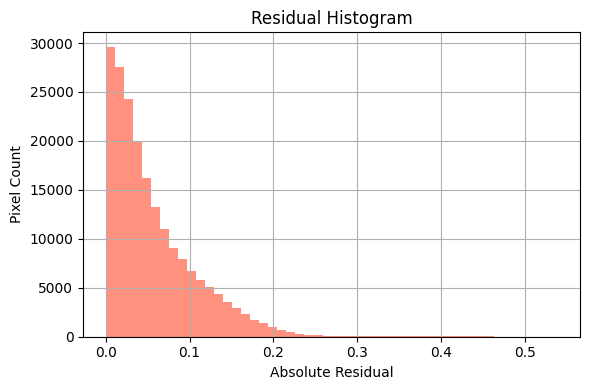

In [26]:
net.eval()
with torch.no_grad():
    for wm_img, ref_img in test_loader:
        # wm_img, ref_img = wm_img.to(device), ref_img.to(device)
        wm_img, ref_img = wm_img.to(device).float() / 255.0, ref_img.to(device).float() / 255.0
        output = net(wm_img)
        plot_residual_histogram(output[0], ref_img[0], save_path="outputs/visuals/residualhistogram.png")
        break

#### Local PSNR/SSIM Maps (Sliding Window)

In [27]:
from skimage.util import view_as_windows

def compute_local_metrics_map(img1, img2, win_size=32, stride=16, metric='psnr'):
    h, w = img1.shape[1], img1.shape[2]
    psnr_map = np.zeros(( (h - win_size) // stride + 1, (w - win_size) // stride + 1))

    for i, y in enumerate(range(0, h - win_size + 1, stride)):
        for j, x in enumerate(range(0, w - win_size + 1, stride)):
            crop1 = img1[:, y:y+win_size, x:x+win_size]
            crop2 = img2[:, y:y+win_size, x:x+win_size]
            if metric == 'psnr':
                score = psnr(crop1.permute(1,2,0).cpu().numpy(), crop2.permute(1,2,0).cpu().numpy(), data_range=1.0)
            elif metric == 'ssim':
                score = ssim(crop1.permute(1,2,0).cpu().numpy(), crop2.permute(1,2,0).cpu().numpy(), data_range=1.0, channel_axis=2)
            psnr_map[i, j] = score
    return psnr_map

def plot_metric_map(map_data, title="Local Metric Map", cmap="magma", save_path=None):
    plt.figure(figsize=(6,5))
    sns.heatmap(map_data, cmap=cmap)
    plt.title(title)
    plt.xlabel("X Patch")
    plt.ylabel("Y Patch")
    plt.tight_layout()

    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close() # to free mem

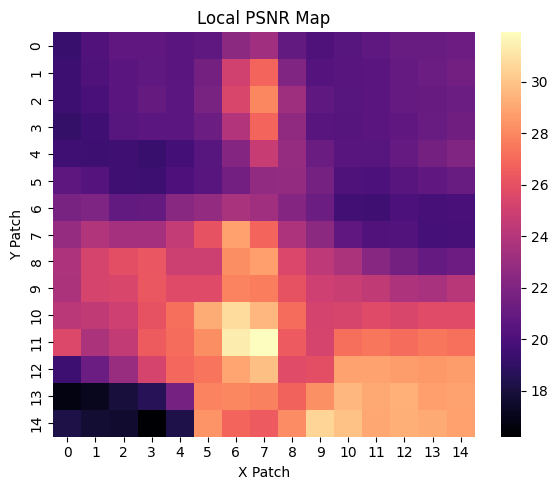

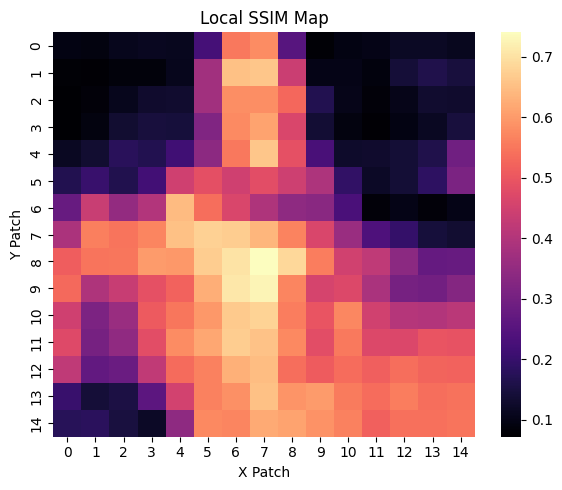

In [28]:
sample_pred = output[0]
sample_ref = ref_img[0]

psnr_map = compute_local_metrics_map(sample_pred, sample_ref, metric='psnr')
plot_metric_map(psnr_map, "Local PSNR Map", save_path="outputs/visuals/local_psnr_map.png")

ssim_map = compute_local_metrics_map(sample_pred, sample_ref, metric='ssim')
plot_metric_map(ssim_map, "Local SSIM Map", save_path="outputs/visuals/local_ssim_map.png")

#### Side by side Comparison Viewer

In [31]:
def visualize_comparison(original, watermarked, predicted, n=3, figsize=(15, 8)):
    """
    Display original/watermarked/predicted images in a grid
    Args:
        original: List/Tensor of original clean images
        watermarked: List/Tensor of watermarked images  
        predicted: List/Tensor of model outputs
        n: Number of examples to show
    """
    plt.figure(figsize=figsize)
    for i in range(n):
        # Convert tensors to PIL if needed
        orig = to_pil_image(original[i]) if torch.is_tensor(original[i]) else original[i]
        wm = to_pil_image(watermarked[i]) if torch.is_tensor(watermarked[i]) else watermarked[i]
        pred = to_pil_image(predicted[i]) if torch.is_tensor(predicted[i]) else predicted[i]
        
        # Plot triplets
        plt.subplot(n, 3, i*3+1)
        plt.imshow(orig)
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(n, 3, i*3+2)
        plt.imshow(wm)
        plt.title("Watermarked")
        plt.axis('off')
        
        plt.subplot(n, 3, i*3+3)
        plt.imshow(pred)
        plt.title("Predicted")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

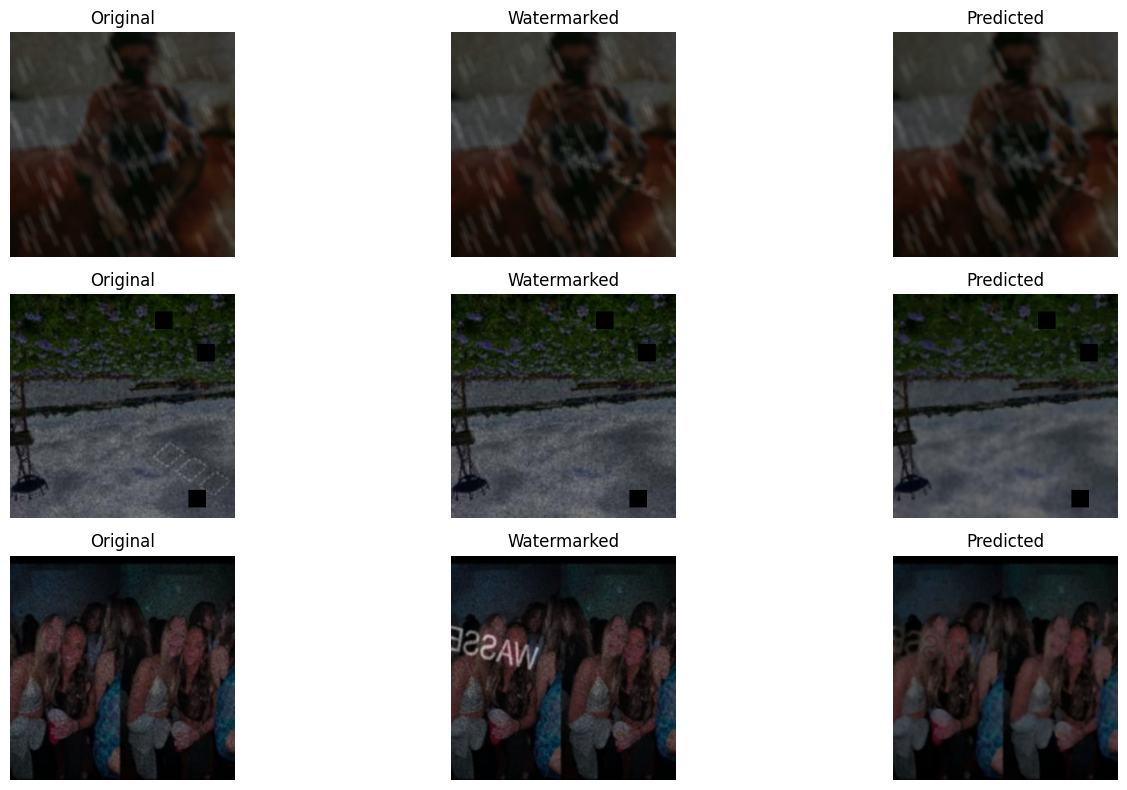

In [32]:
net.eval()
inputs, references = next(iter(test_loader))
inputs = inputs.to(device).float() / 255.0 # convert to float & normalize
references = references.float() / 255.0 # normalize ground truth

with torch.no_grad():
    outputs = net(inputs)

# Call the visualization
visualize_comparison(original=references, watermarked=inputs.cpu(), predicted=outputs.cpu(), n=3)

#### Watermark Residual Visualizer

In [33]:
def show_residuals(watermarked, predicted, original=None, threshold=0.1):
    """
    Highlight remaining watermark artifacts by showing:
    - Absolute difference between watermarked and predicted
    - Thresholded residual map
    """
    if torch.is_tensor(watermarked):
        watermarked = watermarked.detach().cpu().permute(1,2,0).numpy()
    if torch.is_tensor(predicted):
        predicted = predicted.detach().cpu().permute(1,2,0).numpy()
    
    residual = np.abs(watermarked - predicted).mean(axis=-1)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(residual, cmap='jet')
    plt.colorbar()
    plt.title("Residual Heatmap")
    
    plt.subplot(1, 3, 2)
    plt.imshow((residual > threshold).astype(np.uint8), cmap='gray')
    plt.title(f"Thresholded (> {threshold})")
    
    if original is not None:
        if torch.is_tensor(original):
            original = original.detach().cpu().permute(1,2,0).numpy()
        clean_residual = np.abs(original - predicted).mean(axis=-1)
        plt.subplot(1, 3, 3)
        plt.imshow(clean_residual, cmap='jet')
        plt.colorbar()
        plt.title("Original vs Predicted")
    
    plt.tight_layout()
    plt.show()

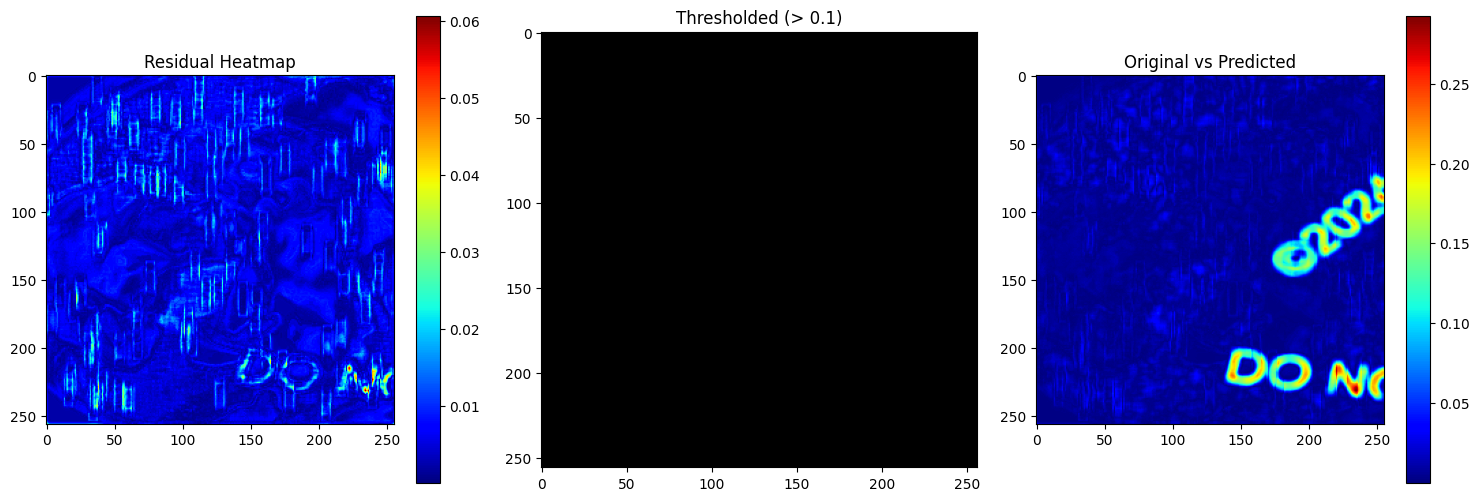

In [34]:
idx = random.randint(0, len(test_dataset) - 1)
sample_input, sample_ref = test_dataset[idx]
sample_input = sample_input.float() / 255.0
sample_ref = sample_ref.float() / 255.0

with torch.no_grad():
    pred = net(sample_input.unsqueeze(0).to(device))[0].cpu()

# Visualize residuals
show_residuals(sample_input, pred, sample_ref)

#### Training Progress Monitor

In [57]:
def plot_metrics(train_losses, val_losses, train_psnr=None, val_psnr=None):
    """Plot training and validation curves"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if train_psnr and val_psnr:
        plt.subplot(1, 2, 2)
        plt.plot(train_psnr, label='Train PSNR')
        plt.plot(val_psnr, label='Val PSNR')
        plt.xlabel('Epoch')
        plt.ylabel('PSNR (dB)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

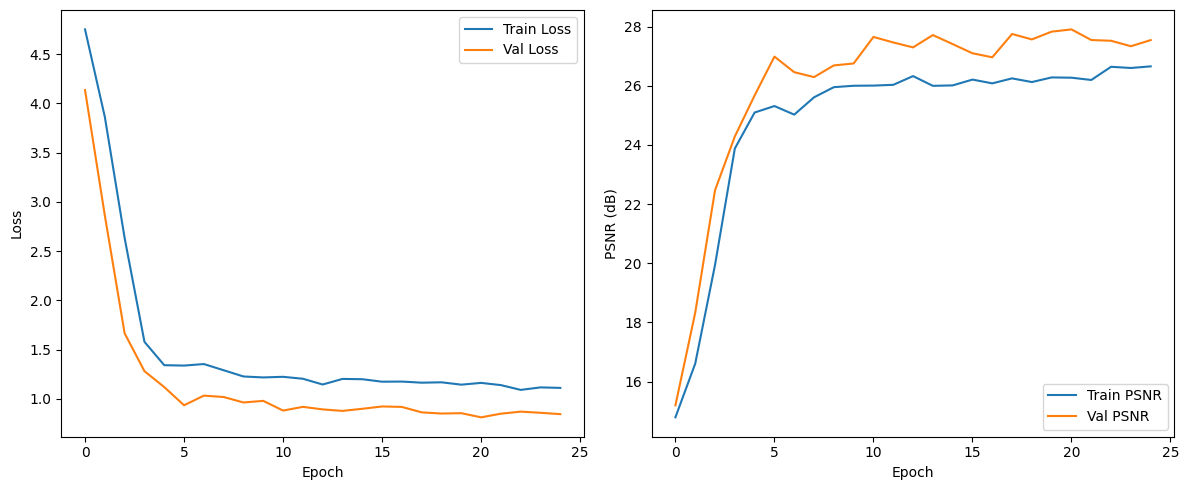

In [58]:
plot_metrics(
    train_losses=train_losses,
    val_losses=val_losses,
    train_psnr=psnr_scores,
    val_psnr=val_psnr_scores
)

#### Watermark Attention Visualizer

In [37]:
def visualize_attention(model, image_tensor, layer_name='dec3'):
    """
    Visualize where the model focuses when removing watermarks
    using intermediate layer activations
    """
    activations = {}
    
    # Hook to capture activations
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hook
    target_layer = getattr(model, layer_name)
    handle = target_layer.register_forward_hook(get_activation(layer_name))
    
    # Forward pass
    with torch.no_grad():
        model(image_tensor.unsqueeze(0).cuda())
    
    # Remove hook
    handle.remove()
    
    # Visualize
    act = activations[layer_name].squeeze().mean(dim=0).cpu()
    act = (act - act.min()) / (act.max() - act.min())
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(to_pil_image(image_tensor.cpu()))
    plt.title("Input")
    
    plt.subplot(1, 2, 2)
    plt.imshow(act, cmap='hot')
    plt.colorbar()
    plt.title("Activation Heatmap")
    plt.show()

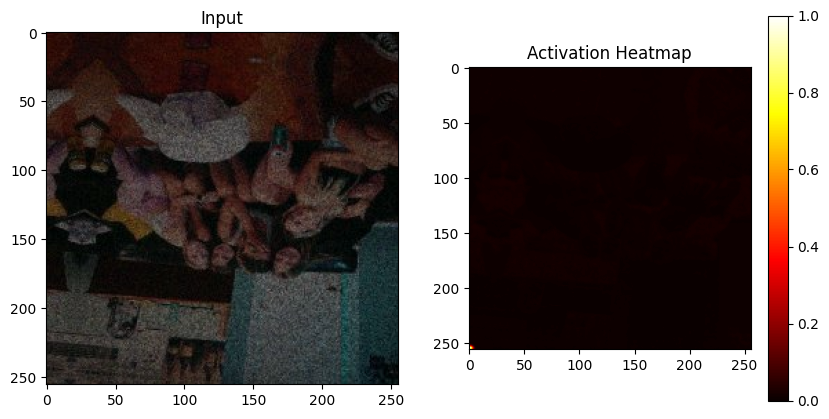

In [38]:
idx = random.randint(0, len(test_dataset) - 1)
# input_tensor = test_dataset[idx][0].to(device)
input_tensor = test_dataset[idx][0].float() / 255.0
input_tensor = input_tensor.to(device)

# Call the visualizer for a decoder layer (e.g., dec3)
visualize_attention(net, input_tensor, layer_name='dec3')

#### Batch Processing Visualizer

In [39]:
def show_batch(dataloader, n=4, augmentations=None):
    """Visualize a batch of training samples with/without augmentations"""
    batch = next(iter(dataloader))
    watermarked, reference = batch[0][:n], batch[1][:n]
    
    plt.figure(figsize=(15, 8))
    for i in range(n):
        # Original pair
        plt.subplot(2, n, i+1)
        plt.imshow(to_pil_image(watermarked[i]))
        plt.title(f"WM {watermarked[i].shape}")
        plt.axis('off')
        
        plt.subplot(2, n, n+i+1)
        plt.imshow(to_pil_image(reference[i]))
        plt.title(f"Ref {reference[i].shape}")
        plt.axis('off')
    
    if augmentations:
        augmented = [augmentations(img) for img in watermarked]
        plt.figure(figsize=(15, 4))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(to_pil_image(augmented[i]))
            plt.title(f"Augmented {i+1}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

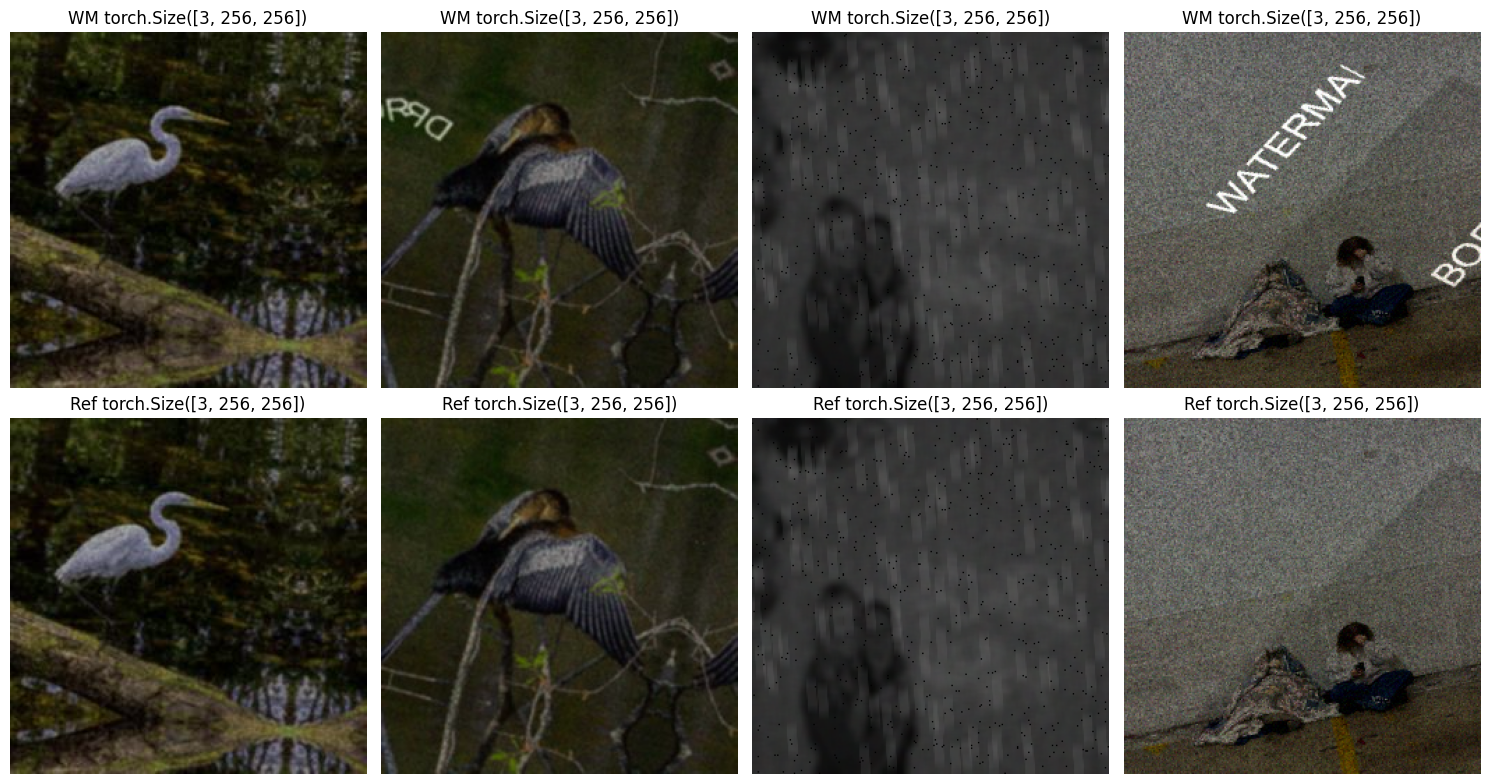

In [40]:
show_batch(train_loader, n=4)

### Visualization of Learning Rate

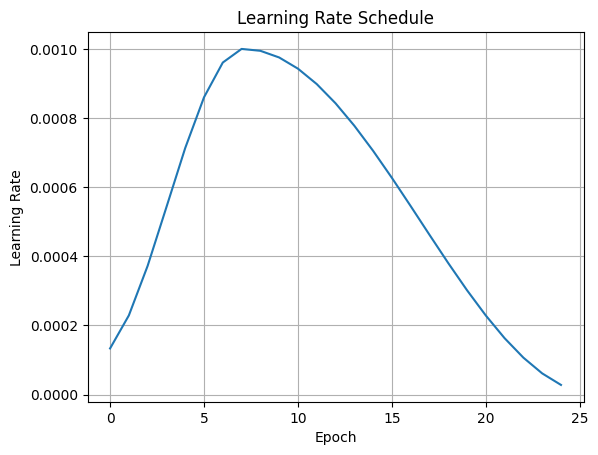

In [41]:
plt.plot(lrs)
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

### Train Loss, Peak Signal-to-Noise Ratio, Structural Similarity Index Plots <a id="train-psnr-ssim-plots"></a>

In [42]:
def plot_metrics(train_losses, psnr_scores, ssim_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Train Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.grid(True)
    plt.legend()

    # PSNR plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, psnr_scores, label="PSNR (dB)", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.title("PSNR Over Time")
    plt.grid(True)
    plt.legend()

    # SSIM plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, ssim_scores, label="SSIM", color="purple")
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.title("SSIM Over Time")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

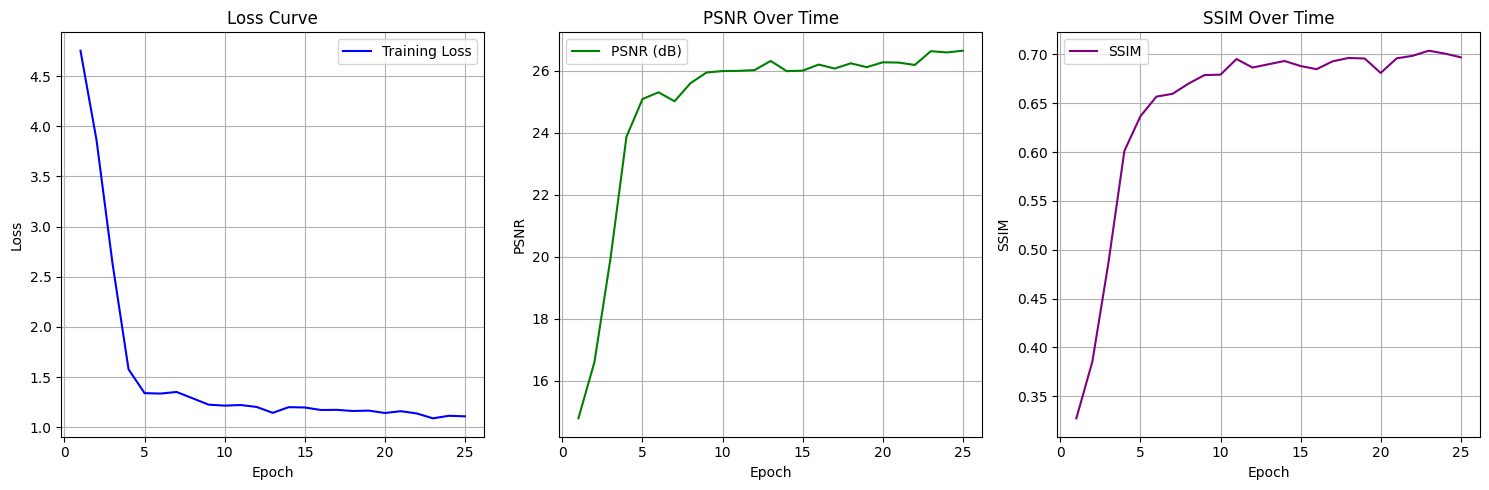

In [43]:
plot_metrics(train_losses, psnr_scores, ssim_scores)

### Residual Error Visualizer Cell

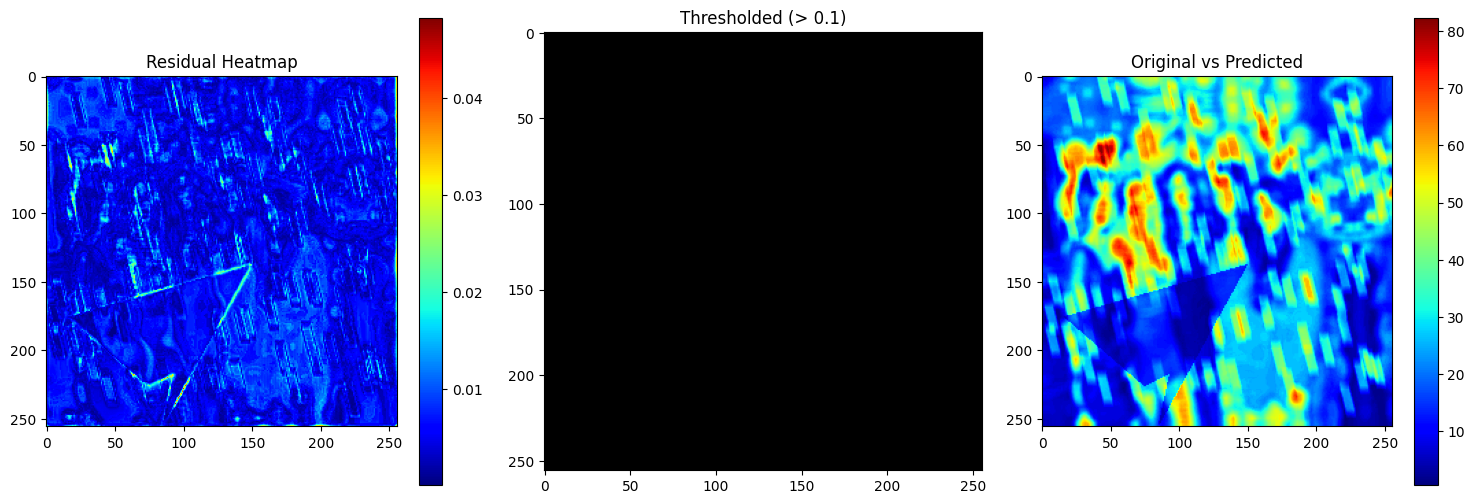

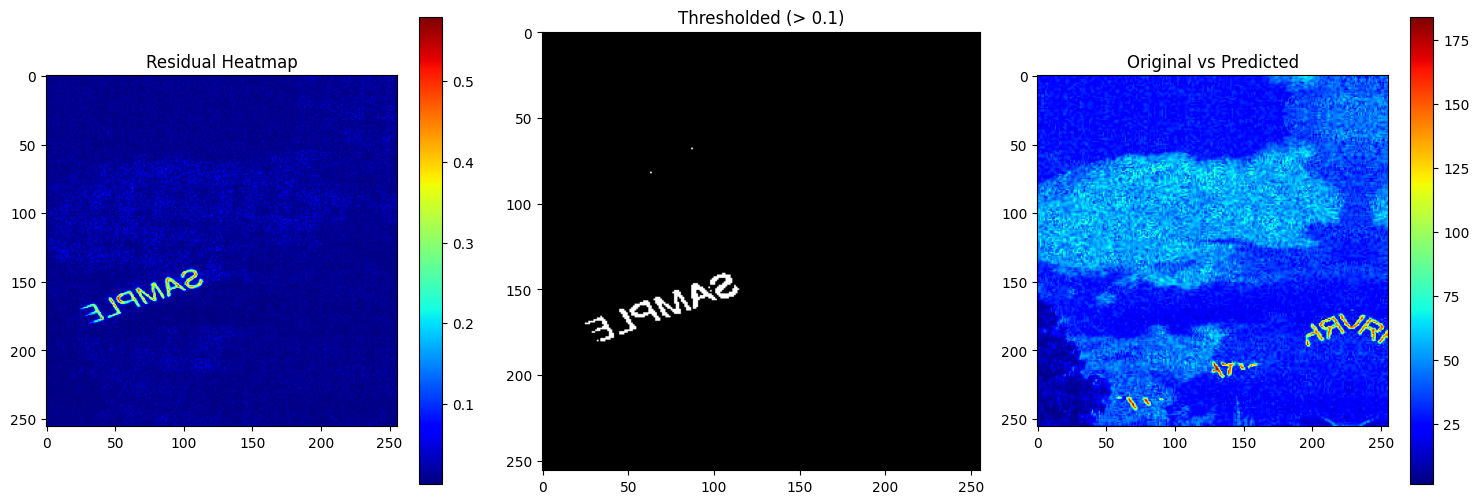

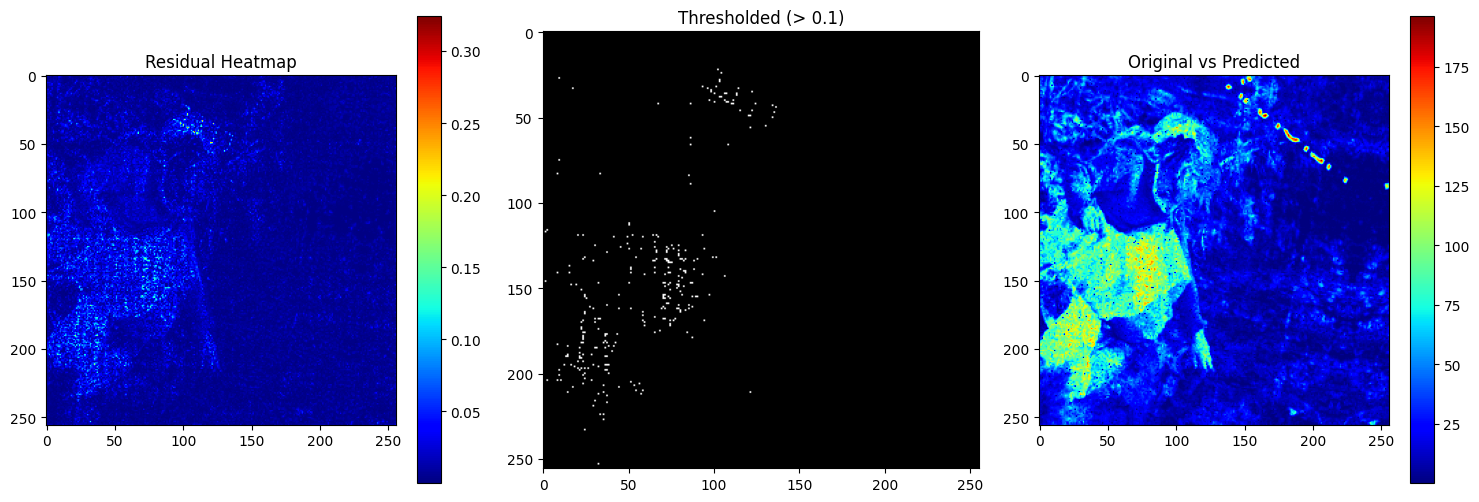

In [44]:
# Visualize residuals after model is trained
net.eval()
with torch.no_grad():
    watermarked_batch, reference_batch, _ = next(iter(train_loader))
    watermarked_batch = watermarked_batch.float() / 255.0  # Convert to float & normalize
    watermarked_batch = watermarked_batch.to(device)
    preds = net(watermarked_batch).cpu()

# Show residuals for first few predictions
for i in range(3):
    show_residuals(watermarked_batch[i].cpu(), preds[i], reference_batch[i])

In [ ]:
# img_tensor = dataset[0][0]  # Just one input image (no batch)
# visualize_activation(net, img_tensor, layer_name='dec3')  # Pick dec1, dec2, dec3, or enc*

### Multi-Layer Activation Visualizer

In [45]:
def compare_layer_activations(net, input_tensor, layers=('enc1', 'enc2', 'dec1', 'dec2', 'dec3')):
    activations = {}

    def make_hook(name):
        def hook_fn(module, input, output):
            activations[name] = output.detach()
        return hook_fn

    hooks = []
    for layer in layers:
        target = getattr(net, layer)
        hooks.append(target.register_forward_hook(make_hook(layer)))

    net.eval()
    with torch.no_grad():
        _ = net(input_tensor.unsqueeze(0).to(device))

    for h in hooks:
        h.remove()

    # Plot all selected layers
    num_layers = len(layers)
    plt.figure(figsize=(5 * num_layers, 4))
    for i, layer in enumerate(layers):
        act = activations[layer].squeeze().mean(dim=0).cpu()
        act = (act - act.min()) / (act.max() - act.min())

        plt.subplot(1, num_layers, i+1)
        plt.imshow(act, cmap='inferno')
        plt.title(layer)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

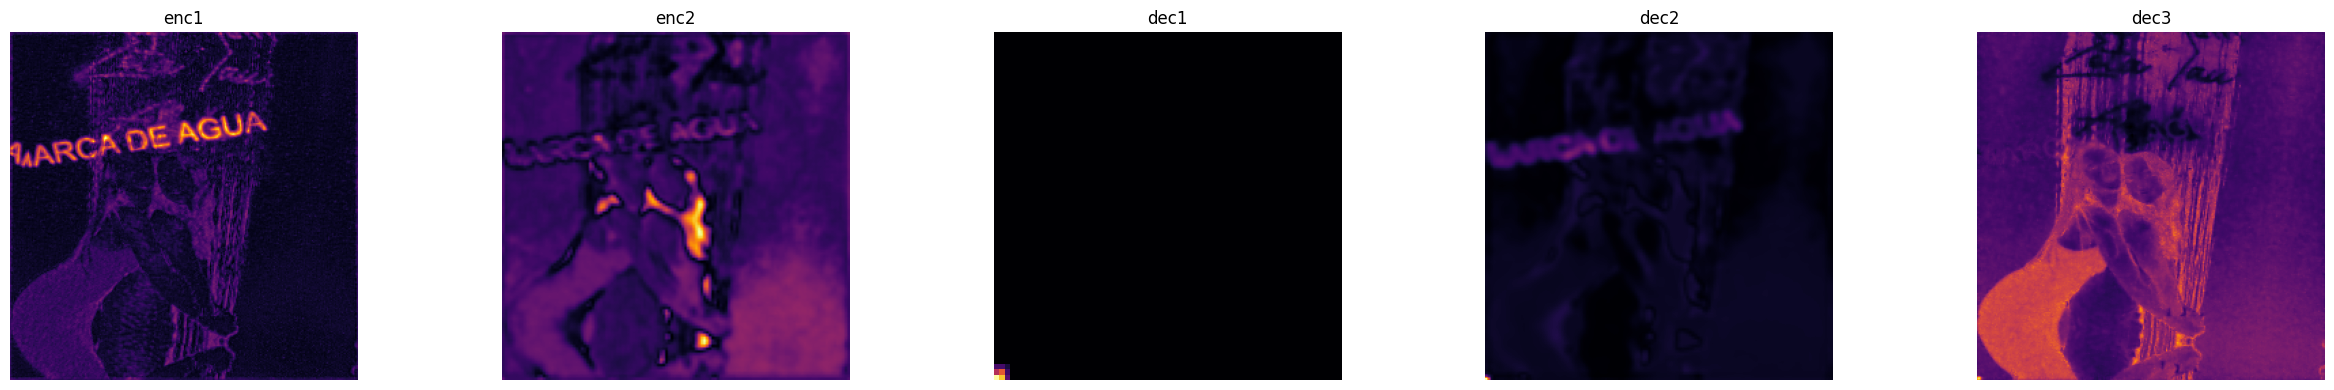

In [46]:
idx = random.randint(0, len(test_dataset) - 1)
sample_image = test_dataset[idx][0].float() / 255.0

compare_layer_activations(net, sample_image, layers=['enc1', 'enc2', 'dec1', 'dec2', 'dec3'])

### Feature Activation Maps (Decoder Focus)<a id="fam-decoderfocus"></a>

In [47]:
def visualize_activation(net, input_tensor, layer_name='dec3'):
    """
    Visualize average channel-wise activation from an intermediate decoder layer.
    """
    activations = {}

    # Hook to capture intermediate activations
    def hook_fn(module, input, output):
        activations[layer_name] = output.detach()

    # Register hook
    hook = getattr(net, layer_name).register_forward_hook(hook_fn)

    # Forward pass
    net.eval()
    with torch.no_grad():
        _ = net(input_tensor.unsqueeze(0).to(device))

    # Remove hook
    hook.remove()

    # Process activation
    act = activations[layer_name].squeeze().mean(dim=0).cpu()
    act = (act - act.min()) / (act.max() - act.min())  # Normalize for display

    # Original image for comparison
    img = to_pil_image(input_tensor.cpu())

    # Plot side by side
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(act, cmap='magma')
    plt.title(f"Activation Heatmap: {layer_name}")
    plt.colorbar()
    plt.axis("off")
    plt.tight_layout()
    plt.show()

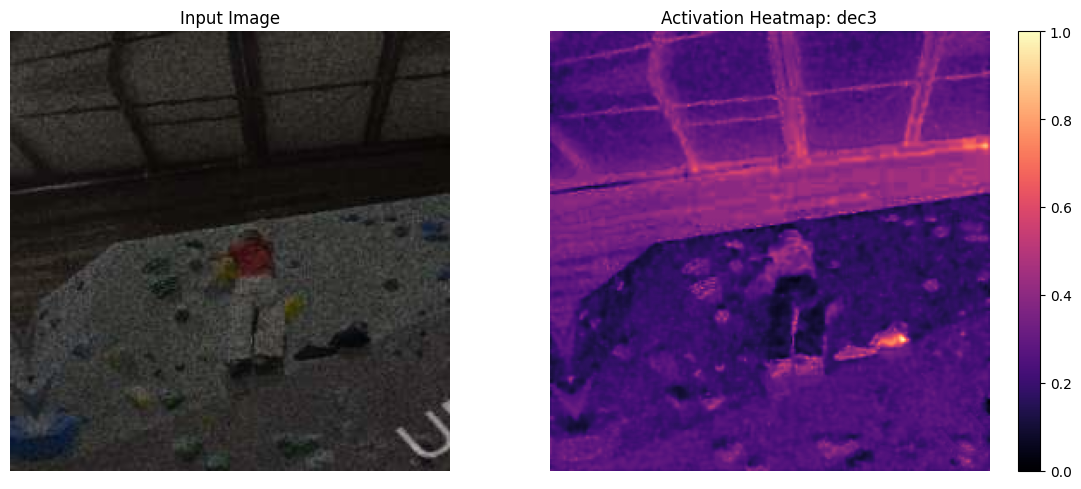

In [48]:
idx = random.randint(0, len(test_dataset) - 1)
sample_image = test_dataset[idx][0].float() / 255.0  # Assuming test_dataset returns a tuple (input, target)

# Visualize the activation map for the specified decoder layer
visualize_activation(net, sample_image, layer_name='dec3')  # You can change 'dec3' to any desired layer

In [ ]:
# Forward pass to extract feature maps
def visualize_feature_maps(model, input_image):
    net.eval()
    layers = list(net.children()) # including encoder & decoder blocks
    for idx, layer in enumerate(layers):
        input_image = layer(input_image)
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Sequential):  # Visualize Conv layers or blocks
            try:
                feature_map = input_image[0]  # First image in batch
                plt.figure(figsize=(15, 10))
                for i in range(min(8, feature_map.size(0))):  # Show up to 8 channels
                    plt.subplot(2, 4, i + 1)
                    plt.imshow(feature_map[i].detach().cpu().numpy(), cmap="viridis")
                    plt.axis("off")
                plt.suptitle(f"Feature Maps after Layer {idx + 1}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Skipping visualization for layer {idx + 1}: {e}")

# Dummy input (same size as your training inputs)
# dummy_input = torch.randn(1, 3, 256, 256).to(device)
# visualize_feature_maps(net, dummy_input)
idx = random.randint(0, len(test_dataset) - 1)
real_input = test_dataset[idx][0].unsqueeze(0).to(device)  # Add batch dimension
visualize_feature_maps(net, real_input)

### Kernel/Visualizations <a id="kernel-visualizations"></a>

In [ ]:
# 1st Conv2D layer in model
first_conv = net.enc1.conv[0]
filters = first_conv.weight.data.cpu()

# Plot filters
fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # 32 filters = 4x8 grid
for i, ax in enumerate(axes.flat):
    if i < filters.size(0):
        # Normalize filter for better visualization
        f = filters[i]
        f_min, f_max = f.min(), f.max()
        f_img = (f - f_min) / (f_max - f_min)
        f_img = f_img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
        ax.imshow(f_img.numpy())
        ax.axis("off")

plt.suptitle("Filters in the First Convolutional Layer")
plt.tight_layout()
plt.show()

### Gradient Visualization <a id="gradient-visualizations"></a>

In [ ]:
def visualize_gradients(net, input_image, reference_image):
    input_image = input_image.unsqueeze(0).to(device).clone().detach().requires_grad_(True)
    reference_image = reference_image.unsqueeze(0).to(device)
    
    net.eval()
    output = net(input_image)
    loss = nn.MSELoss()(output, reference_image)
    loss.backward()
    
    gradients = input_image.grad.data.cpu().squeeze().numpy()
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())  # Normalize
    
    # Visualize gradients
    plt.figure(figsize=(6, 4))
    plt.imshow(np.moveaxis(gradients, 0, -1))  # Convert from (C, H, W) to (H, W, C)
    plt.title("Input Gradient Map (MSE Loss)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
idx = random.randint(0, len(test_dataset) - 1)
sample_wm, sample_ref = test_dataset[idx]
sample_wm = sample_wm.float() / 255.0
sample_ref = sample_ref.float() / 255.0
visualize_gradients(net, sample_wm, sample_ref)

# **Literature Cited** <a id="litcit"></a>

> [1] C. Tian, M. Zheng, T. Jiao, W. Zuo, Y. Zhang, and C.-W. Lin, "A self-supervised CNN for image watermark removal," 
*arXiv preprint* arXiv:2403.05807, 2024. [Online]. Available: https://arxiv.org/abs/2403.05807

> Dougherty, G. *Pattern Recognition and Classification: An Introduction*. Springer, 2012.

> Eliot, D. *Deep Learning with PyTorch Step-by-Step: A Beginner's Guide, Volume I: Fundamentals*. Self-published, 2020.

# **Environment**

- **Local Environment: My Laptop**
  - **Make & Model** Alienware m15 R7
  - **GPU:** NVIDIA GeForce RTX 3060 Mobile (6 GB VRAM)
  - **Secondary GPU:** Integrated AMD Radeon Graphics
  - **CPU:** AMD Ryzen 7 6800H (16 threads @ 4.78 GHz)
  - **RAM:** 16 GB DDR5
  - **CUDA Version:** CUDA Version: 12.8
  - **Operating System:** Pop!_OS 22.04 LTS
  - **Kernel:** 6.12.10-76061203-generic

# **Recommended Resources** <a id="recres"></a>

<p>Resources that I found useful while working on this Computer Vision project and or learning about Machine Learning & AI in general.</p>

<ul>
  <li>
    <a href="https://greenteapress.com/thinkpython2/thinkpython2.pdf" target="_blank">
      Think Python How to Think Like a Computer Scientist 2nd Edition, Version 2.4.0 by Allen Downey
    </a>
  </li>
    <li>
    <a href="https://github.com/dvgodoy/PyTorchStepByStep/blob/master/README.md" target="_blank">
      Deep Learning with PyTorch Step-by-Step: A Beginner's Guide: Volume I: Fundamentals by Daniel Voigt Godoy
    </a>
  </li>

  <li>
    <a href="https://link.springer.com/book/10.1007/978-1-4614-5323-9" target="_blank">
      Pattern Recognition and Classification An Introduction (Springer, 2012) by Geoff Dougherty
    </a>
  </li>

  <li>
    <a href="https://www.amazon.com/author/msoltys" target="_blank">
      An Introduction to the Analysis of Algorithms (3rd Ed, 2018) by Michael Soltys
    </a>
  </li>

  <li>
    <a href="https://docs.ultralytics.com/models/yolov8/" target="_blank">
      Ultralytics YOLOv8 Documentation
    </a>
  </li>

  <li>
    <a href="https://shisrrj.com/paper/SHISRRJ247267.pdf" target="_blank">
      Object Detection and Localization with YOLOv3 by B. Rupadevi and J. Pallavi
    </a>
  </li>

  <li>
    <a href="https://www.amazon.com/Digital-Image-Processing-Medical-Applications/dp/0521860857" target="_blank">
      Digital Image Processing for Medical Applications by Geoff Dougherty
    </a>
  </li>
</ul>

# **Permission**

Students and anyone else for that matter wanting to practice and learn Neural Networks, Computer Vision, Machine learning, Deep Learning, AI, or any other relevent word or buzzword, please feel free to use this use this notebook as a resource. 

It was part of my Capstone Project for my Bachelors in Computer Science at California State University Channel Islands. I structured it in a digestible way for myself while getting comfortable with this area of AI/ML. 

Maybe it will be of use to one of you reading this. Grasping everything can be a little overwhelming at first so my hope is that this notebook will help some become more comfortable with ***Neural Networks***. Everyone has my permission to download, use, edit, reference the notebooks, the python code, and the html in MarkDown Cells. If I am not mistaken, these explanations in this notebook are accepted as being true in/for Computer Vision ML/AI. I am open to being wrong or corrected as I am still learning. This is a learning resource - Ian Ryan